# GradCAM Visualization for Trained Model

This notebook loads the trained DenseNet-121 model and visualizes GradCAM activations on test images.

In [1]:
# Import Required Libraries
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from tqdm import tqdm

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as F

import sys
sys.path.append('..')
from experiments.squeeze_excitation_experiment import create_model_for_experiment

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Load the Trained Model

Load the model from the checkpoint file.

In [2]:
# Load model checkpoint
checkpoint_path = '../trained_models/Definitive model/best_test_accuracy.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model instance with SE blocks (same architecture as training)
model = create_model_for_experiment("Sweep", num_classes=8)

# Load weights
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded from {checkpoint_path}")
print(f"Training epoch: {checkpoint['epoch']}")
print(f"Device: {device}")

Model loaded from ../trained_models/Definitive model/best_test_accuracy.pt
Training epoch: 40
Device: cpu


/tmp/ipykernel_2853722/4053867985.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


## Load Test Dataset and Evaluate Accuracy

In [3]:
# Prepare test data
IMG_SIZE = 224
test_transformation = F.Compose([
    F.ToImage(),
    F.ToDtype(torch.float32, scale=True),
    F.Resize(size=(IMG_SIZE, IMG_SIZE)),
])

test_folder = os.path.expanduser('/ghome/mcv/datasets/C3/2425/MIT_small_train_1/test')
data_test = ImageFolder(test_folder, transform=test_transformation)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False, num_workers=4)

print(f"Test dataset loaded: {len(data_test)} images")
print(f"Classes: {data_test.classes}")

Test dataset loaded: 2288 images
Classes: ['Opencountry', 'coast', 'forest', 'highway', 'inside_city', 'mountain', 'street', 'tallbuilding']


In [4]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    pbar = tqdm(test_loader, desc="Evaluating", unit="batch")
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Opcional: Actualizar la barra con el accuracy actual
        current_acc = 100 * correct / total
        pbar.set_postfix(acc=f"{current_acc:.2f}%")

test_accuracy = correct / total
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Correct predictions: {correct}/{total}")

Evaluating: 100%|██████████| 72/72 [01:10<00:00,  1.03batch/s, acc=95.63%]


Test Accuracy: 0.9563 (95.63%)
Correct predictions: 2188/2288


## Select Random Test Image and Visualize GradCAM

Showing image index: 1718
Selected image: /ghome/mcv/datasets/C3/2425/MIT_small_train_1/test/mountain/sharp66.jpg
True class: mountain (label: 5)
Predicted class: mountain (label: 5)
Confidence: 0.9483


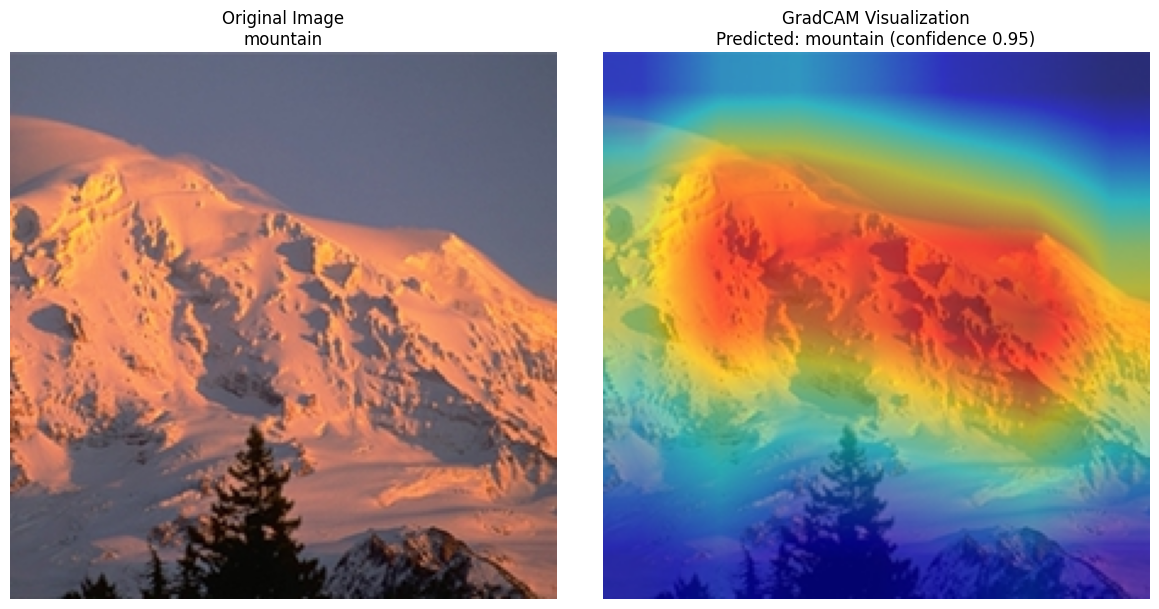

In [19]:
# Select a random test image
#idx = random.randint(0, len(data_test) - 1)
idx=1718
print("Showing image index:", idx)


img_path, label = data_test.samples[idx]
class_name = data_test.classes[label]

print(f"Selected image: {img_path}")
print(f"True class: {class_name} (label: {label})")

# Load and preprocess image
img = Image.open(img_path).convert('RGB')
img_tensor = test_transformation(img).unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = model(img_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = output.argmax(1).item()
    confidence = probabilities[0, predicted_class].item()

predicted_name = data_test.classes[predicted_class]
print(f"Predicted class: {predicted_name} (label: {predicted_class})")
print(f"Confidence: {confidence:.4f}")


# Generate GradCAM visualization

target_layer = [model.backbone.features[-1]]  # Last convolutional layer
targets = [ClassifierOutputTarget(predicted_class)]

# Prepare image for GradCAM overlay (needs to be numpy array in [0, 1] range)
img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
img_normalized = img_array.astype(np.float32) / 255.0

# Extract GradCAM
grad_cams = model.extract_grad_cam(
    input_image=img_tensor, 
    target_layer=target_layer, 
    targets=targets
)

# Create visualization
visualization = show_cam_on_image(img_normalized, grad_cams, use_rgb=True)

# Display GradCAM
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_normalized)
axes[0].set_title(f'Original Image\n{class_name}')
axes[0].axis('off')

axes[1].imshow(visualization)
axes[1].set_title(f'GradCAM Visualization\nPredicted: {predicted_name} (confidence {confidence:.2f})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Visualize GradCAM for One Sample Per Class

Generate one random sample for each class in the dataset.

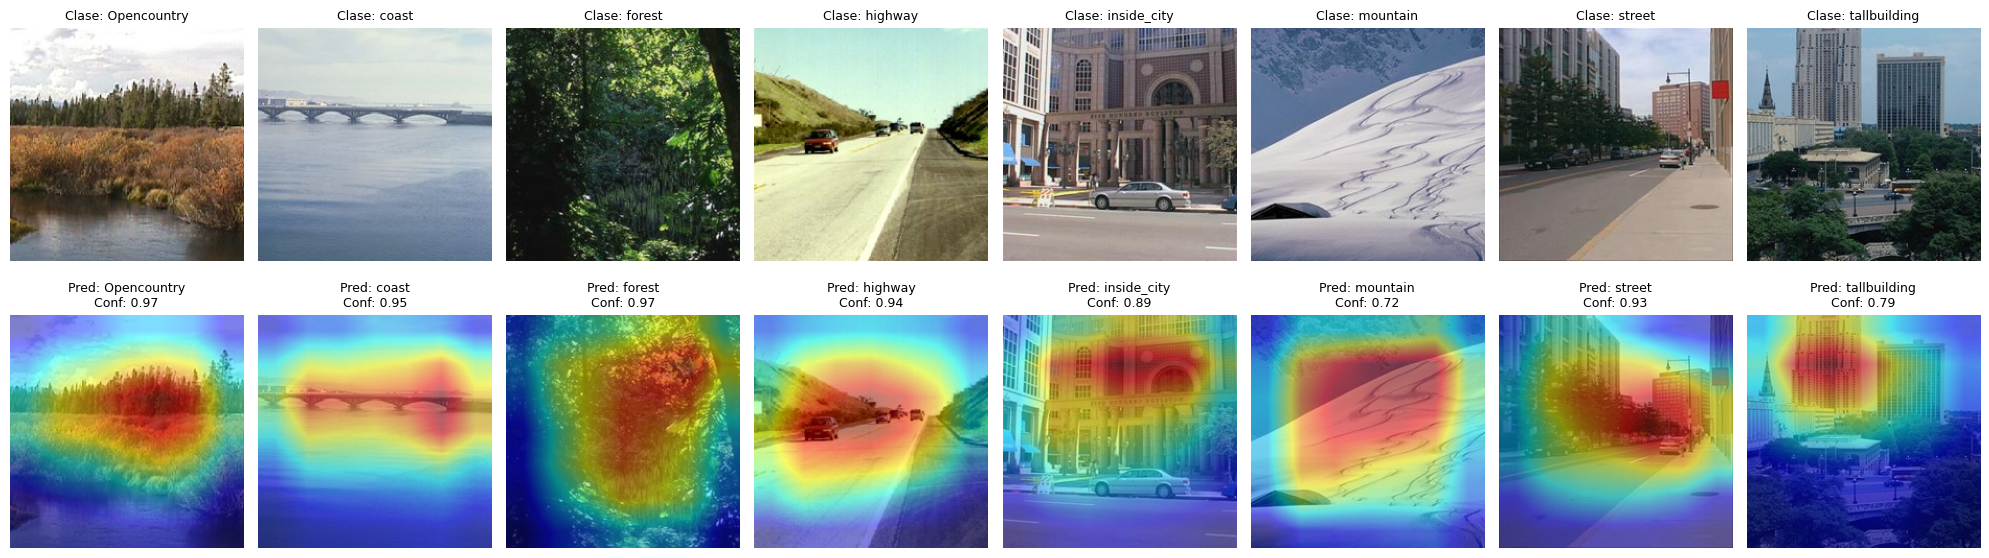

In [ ]:
num_classes = len(data_test.classes)

# Get indices for each class
class_indices = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(data_test.samples):
    class_indices[label].append(idx)

selected_indices = []
for class_id in range(num_classes):
    if len(class_indices[class_id]) > 0:
        random_idx = random.choice(class_indices[class_id])
        selected_indices.append(random_idx)
    else:
        selected_indices.append(None)

print("Selected indices per class:")
for class_id, idx in enumerate(selected_indices):
    if idx is not None:
        print(f"  Class {class_id} ({data_test.classes[class_id]}): index {idx}")

# Definimos el número de imágenes (asumiendo 8 para las 8 clases)
num_images = len([idx for idx in selected_indices if idx is not None])
cols = num_images  # Las 8 columnas
rows = 2           # Una fila para original, otra para GradCAM

fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 6))

# Nos aseguramos de que axes sea siempre una matriz 2D para poder usar [row, col]
if cols == 1:
    axes = axes.reshape(2, 1)

plot_idx = 0
for class_id, idx in enumerate(selected_indices):
    if idx is None:
        continue
    
    # --- CARGA Y PROCESAMIENTO ---
    img_path, label = data_test.samples[idx]
    class_name = data_test.classes[label]
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transformation(img).unsqueeze(0).to(device)
    
    # Inferencia
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = output.argmax(1).item()
        confidence = probabilities[0, predicted_class].item()
    
    predicted_name = data_test.classes[predicted_class]
    
    # Preparar imagen para visualizar
    img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
    img_normalized = img_array.astype(np.float32) / 255.0
    
    # --- GENERAR GRAD-CAM ---
    targets = [ClassifierOutputTarget(predicted_class)]
    grad_cams = model.extract_grad_cam(
        input_image=img_tensor,
        target_layer=target_layer,
        targets=targets
    )
    visualization = show_cam_on_image(img_normalized, grad_cams, use_rgb=True)
    
    # --- PLOT EN LA GRILLA ---
    # Fila 0: Originales
    axes[0, plot_idx].imshow(img_normalized)
    axes[0, plot_idx].set_title(f'Clase: {class_name}', fontsize=9)
    axes[0, plot_idx].axis('off')
    
    # Fila 1: GradCAM
    axes[1, plot_idx].imshow(visualization)
    axes[1, plot_idx].set_title(f'Pred: {predicted_name}\nConf: {confidence:.2f}', fontsize=9)
    axes[1, plot_idx].axis('off')
    
    plot_idx += 1

plt.tight_layout()
plt.show()

## Visualize GradCAM for Misclassified Samples

For each class, find a misclassified sample and show GradCAM for both the Ground Truth class and the Predicted class (with their confidences).

Found 8/8 misclassified samples
  Class Opencountry: index 7
  Class coast: index 368
  Class forest: index 675
  Class highway: index 959
  Class inside_city: index 1301
  Class mountain: index 1440
  Class street: index 1782
  Class tallbuilding: index 1987


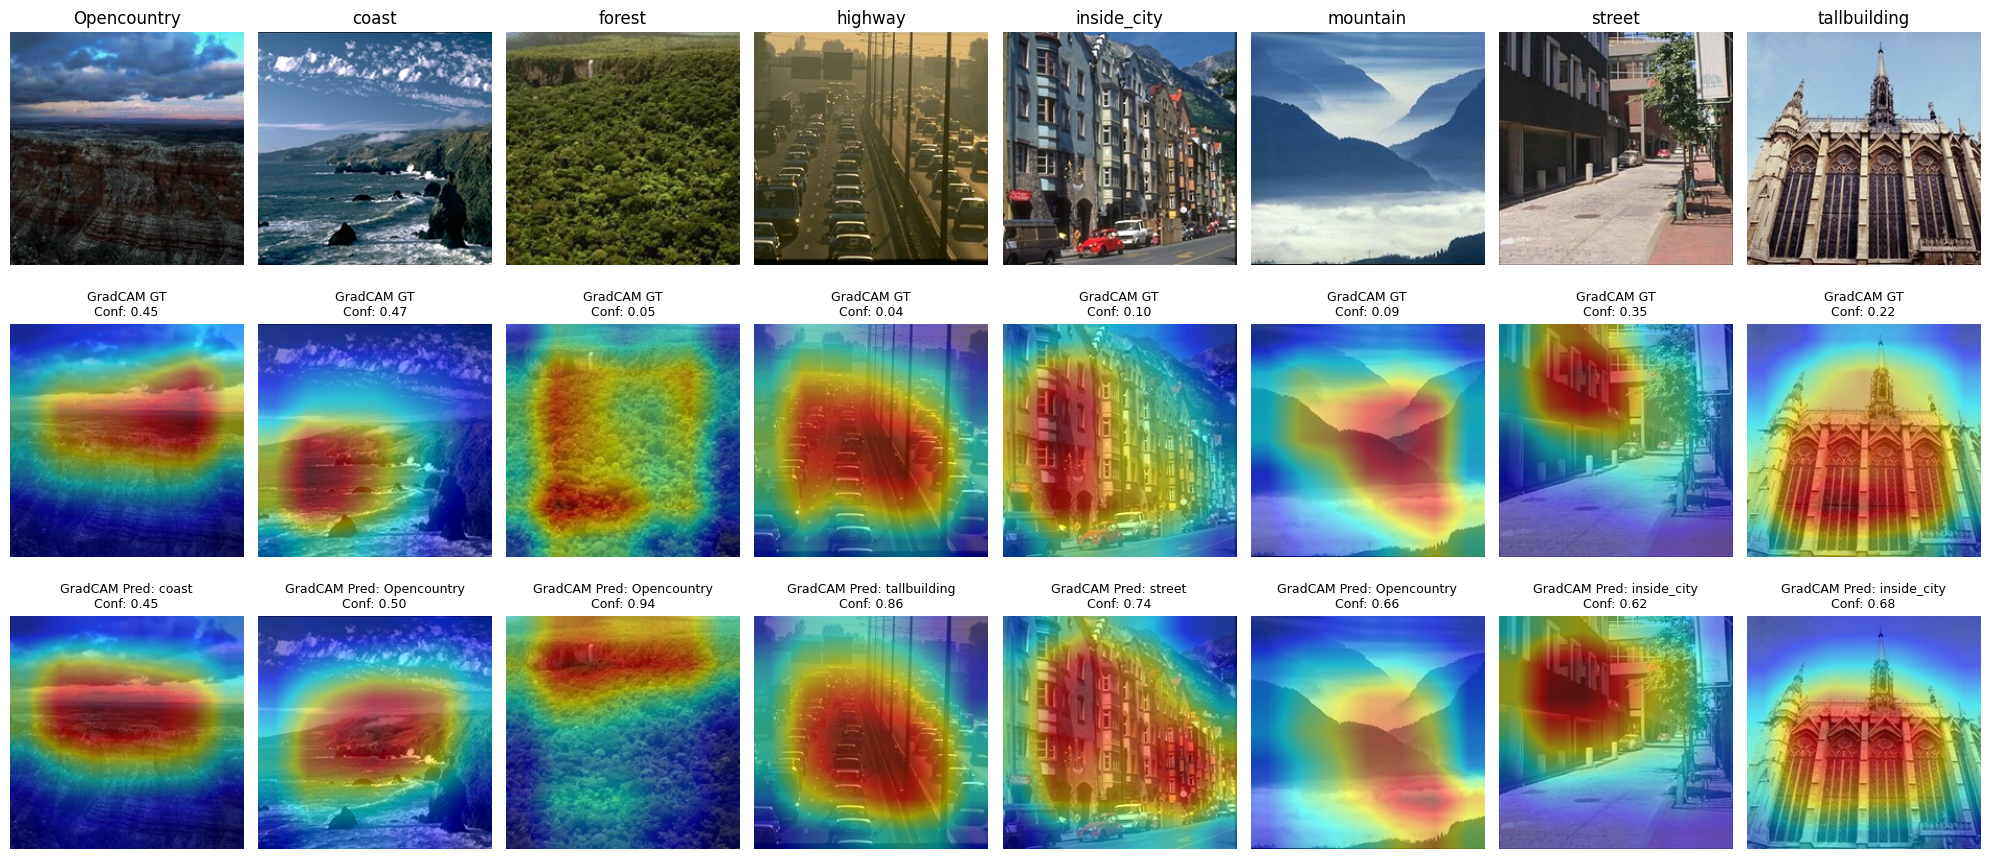

In [ ]:
# Find misclassified samples - one per class (based on GT label)
misclassified_indices = [None] * len(data_test.classes)

for idx in range(len(data_test)):
    img_path, true_label = data_test.samples[idx]
    
    # Skip if we already have a misclassified sample for this GT class
    if misclassified_indices[true_label] is not None:
        continue
    
    # Get prediction for this image
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transformation(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        predicted_class = output.argmax(1).item()
    
    # Check if misclassified
    if predicted_class != true_label:
        misclassified_indices[true_label] = idx
    
    # Stop if we found one for each class
    if all(idx is not None for idx in misclassified_indices):
        break

# Visualize misclassified samples with GradCAM for both GT and Pred classes
num_samples = len([idx for idx in misclassified_indices if idx is not None])
cols = num_samples
rows = 3  # Original, GradCAM for GT, GradCAM for Pred

fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 9))

# Ensure axes is always 2D
if cols == 1:
    axes = axes.reshape(3, 1)

plot_idx = 0
for class_id, idx in enumerate(misclassified_indices):
    if idx is None:
        continue
    
    # --- LOAD AND PROCESS IMAGE ---
    img_path, true_label = data_test.samples[idx]
    true_class_name = data_test.classes[true_label]
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transformation(img).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = output.argmax(1).item()
        pred_confidence = probabilities[0, predicted_class].item()
        gt_confidence = probabilities[0, true_label].item()
    
    predicted_class_name = data_test.classes[predicted_class]
    
    # Prepare image for visualization
    img_array = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
    img_normalized = img_array.astype(np.float32) / 255.0
    
    # --- GENERATE GRAD-CAM FOR GT CLASS ---
    targets_gt = [ClassifierOutputTarget(true_label)]
    grad_cams_gt = model.extract_grad_cam(
        input_image=img_tensor,
        target_layer=target_layer,
        targets=targets_gt
    )
    visualization_gt = show_cam_on_image(img_normalized, grad_cams_gt, use_rgb=True)
    
    # --- GENERATE GRAD-CAM FOR PREDICTED CLASS ---
    targets_pred = [ClassifierOutputTarget(predicted_class)]
    grad_cams_pred = model.extract_grad_cam(
        input_image=img_tensor,
        target_layer=target_layer,
        targets=targets_pred
    )
    visualization_pred = show_cam_on_image(img_normalized, grad_cams_pred, use_rgb=True)
    
    # --- PLOT IN GRID ---
    # Row 0: Original images
    axes[0, plot_idx].imshow(img_normalized)
    axes[0, plot_idx].set_title(f'{true_class_name}', fontsize=12)
    axes[0, plot_idx].axis('off')
    
    # Row 1: GradCAM for GT class
    axes[1, plot_idx].imshow(visualization_gt)
    axes[1, plot_idx].set_title(f'GradCAM GT\nConf: {gt_confidence:.2f}', fontsize=9)
    axes[1, plot_idx].axis('off')
    
    # Row 2: GradCAM for Predicted class
    axes[2, plot_idx].imshow(visualization_pred)
    axes[2, plot_idx].set_title(f'GradCAM Pred: {predicted_class_name}\nConf: {pred_confidence:.2f}', fontsize=9)
    axes[2, plot_idx].axis('off')
    
    plot_idx += 1

plt.tight_layout()
plt.show()